In [1]:
# importing necessary libraries
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, TheilSenRegressor, Ridge, LassoCV
from sklearn.ensemble import RandomForestRegressor, VotingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings("ignore")

In [2]:
# importing the different files
rain = pd.read_csv("rainfall.csv")
temp = pd.read_csv("temp.csv")
mal = pd.read_csv("malaria.csv")

# handling a potential issue
mal['Month'] = mal['Month'].str.upper()

# merging them all into a single DataFrame
df1 = pd.merge(rain, temp, on=['Year', 'Month'])
df = pd.merge(df1, mal, on=['Year', 'Month'])
df

,Year,Month,Rainfall,Temperature,Malaria
0,2014,JAN,0.0,26.9,1293
1,2014,FEB,0.0,28.4,38
2,2014,MAR,0.0,33.6,3155
3,2014,APR,0.0,35.8,3048
4,2014,MAY,22.6,34.6,3442
...,...,...,...,...,...
115,2023,AUG,185.0,26.5,11974
116,2023,SEP,69.4,28.8,11022
117,2023,OCT,13.6,31.7,5022
118,2023,NOV,0.0,30.4,1560


In [3]:
df.columns

Index(['Year', 'Month', 'Rainfall', 'Temperature', 'Malaria'], dtype='object')

In [4]:
# looking at the descriptive statistics of the data
df.describe()

,Year,Rainfall,Temperature,Malaria
count,120.000000,120.000000,120.000000,120.000000
mean,2018.500000,58.813333,30.991667,3043.925000
std,2.884324,95.943806,3.772737,3659.500042
min,2014.000000,0.000000,22.400000,7.000000
25%,2016.000000,0.000000,28.275000,372.250000
50%,2018.500000,0.000000,31.000000,1201.500000
75%,2021.000000,89.525000,34.000000,4506.000000
max,2023.000000,376.200000,41.600000,13255.000000


In [5]:
# looking out for missing values
missing = df.isnull().sum()
print(missing)
print(f"\nThere are {missing.sum()} number of missing values in the dataframe")

Year           0
Month          0
Rainfall       0
Temperature    0
Malaria        0
dtype: int64

There are 0 number of missing values in the dataframe


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Year         120 non-null    int64  
 1   Month        120 non-null    object 
 2   Rainfall     120 non-null    float64
 3   Temperature  120 non-null    float64
 4   Malaria      120 non-null    int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 4.8+ KB


In [7]:
# Function that does some basic data cleaning
def cleaned_df(data):

    # makes the column heading into lower case for ease of calling
    data.columns = data.columns.str.lower()
    
    # creates a new column that converts the 'year' column from int into datetime format
    data['date'] = pd.to_datetime(data['year'], format='%Y').dt.year

    # and drops the existing 'year' column
    data.drop(columns='year', inplace=True)\
    
    data['month'] = data['month'].str.title()
    
    return

In [8]:
cleaned_df(df)
df

,month,rainfall,temperature,malaria,date
0,Jan,0.0,26.9,1293,2014
1,Feb,0.0,28.4,38,2014
2,Mar,0.0,33.6,3155,2014
3,Apr,0.0,35.8,3048,2014
4,May,22.6,34.6,3442,2014
...,...,...,...,...,...
115,Aug,185.0,26.5,11974,2023
116,Sep,69.4,28.8,11022,2023
117,Oct,13.6,31.7,5022,2023
118,Nov,0.0,30.4,1560,2023


In [9]:
# reinspecting the datatypes
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120 entries, 0 to 119
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   month        120 non-null    object 
 1   rainfall     120 non-null    float64
 2   temperature  120 non-null    float64
 3   malaria      120 non-null    int64  
 4   date         120 non-null    int32  
dtypes: float64(2), int32(1), int64(1), object(1)
memory usage: 4.3+ KB


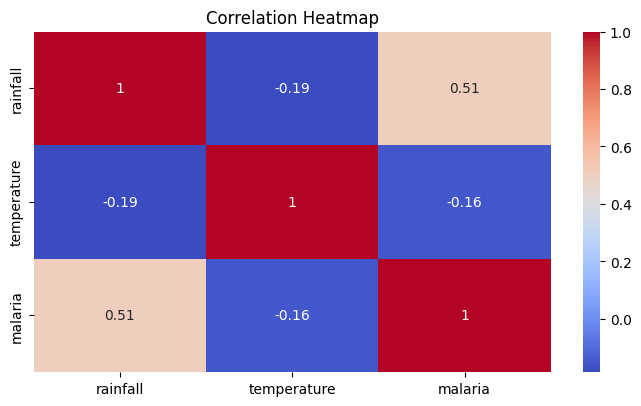

In [10]:
# inspecting correlation between Numeric features

fig, ax = plt.subplots(figsize=(7, 4))
corrs = df.select_dtypes(["int64", "float64"]).corr()
sns.heatmap(corrs, annot=True, cmap='coolwarm')
fig.tight_layout()
plt.title("Correlation Heatmap");

In [11]:
# creating a new column that maps the 'month' column into numerics

# Original array of months
months = np.array(['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])


# Use pd.get_dummies() to create binary columns for each month
dummies = pd.get_dummies(df['month'], prefix='month')

# Create a dictionary mapping month names to their numerical order
month_to_num = {month: i+1 for i, month in enumerate(months)}

# Use the dummy variables to create numerical representations
df['month_num'] = (dummies * dummies.columns.map(lambda x: month_to_num[x.split('_')[1]])).sum(axis=1)

# Display the result
df.head(100)


,month,rainfall,temperature,malaria,date,month_num
0,Jan,0.0,26.9,1293,2014,1
1,Feb,0.0,28.4,38,2014,2
2,Mar,0.0,33.6,3155,2014,3
3,Apr,0.0,35.8,3048,2014,4
4,May,22.6,34.6,3442,2014,5
...,...,...,...,...,...,...
95,Dec,0.0,25.7,724,2021,12
96,Jan,0.0,24.5,469,2022,1
97,Feb,0.0,37.4,925,2022,2
98,Mar,0.0,32.4,101,2022,3


In [12]:
# creating a new faeture called "season" that maps months into seasons

df['season'] = pd.cut(df['month_num'], 
                      bins=[0, 4, 11, 12], 
                      labels=['Dry', 'Rainy', 'Harmattan'], 
                      include_lowest=True)
df

,month,rainfall,temperature,malaria,date,month_num,season
0,Jan,0.0,26.9,1293,2014,1,Dry
1,Feb,0.0,28.4,38,2014,2,Dry
2,Mar,0.0,33.6,3155,2014,3,Dry
3,Apr,0.0,35.8,3048,2014,4,Dry
4,May,22.6,34.6,3442,2014,5,Rainy
...,...,...,...,...,...,...,...
115,Aug,185.0,26.5,11974,2023,8,Rainy
116,Sep,69.4,28.8,11022,2023,9,Rainy
117,Oct,13.6,31.7,5022,2023,10,Rainy
118,Nov,0.0,30.4,1560,2023,11,Rainy


In [13]:
# Temperature and rainfall interaction
df['temp_rain_interaction'] = df['temperature'] * df['rainfall']
df

,month,rainfall,temperature,malaria,date,month_num,season,temp_rain_interaction
0,Jan,0.0,26.9,1293,2014,1,Dry,0.00
1,Feb,0.0,28.4,38,2014,2,Dry,0.00
2,Mar,0.0,33.6,3155,2014,3,Dry,0.00
3,Apr,0.0,35.8,3048,2014,4,Dry,0.00
4,May,22.6,34.6,3442,2014,5,Rainy,781.96
...,...,...,...,...,...,...,...,...
115,Aug,185.0,26.5,11974,2023,8,Rainy,4902.50
116,Sep,69.4,28.8,11022,2023,9,Rainy,1998.72
117,Oct,13.6,31.7,5022,2023,10,Rainy,431.12
118,Nov,0.0,30.4,1560,2023,11,Rainy,0.00


In [14]:
population = 137_900  # 2022 population
area = 2_378  # km²
population_density = population / area

df['cases_per_capita'] = df['malaria'] / population
df['cases_per_km2'] = df['malaria'] / area

# 7. Rate of change
df['rainfall_change'] = df['rainfall'].diff()
df['temperature_change'] = df['temperature'].diff()

# 8. Normalized features
df['rainfall_zscore'] = zscore(df['rainfall'])
df['temperature_zscore'] = zscore(df['temperature'])

# 9. Cumulative features
df['cumulative_rainfall'] = df['rainfall'].cumsum()
df['cumulative_temperature'] = df['temperature'].cumsum()

# 10. Humidity index (simplified)
df['humidity_index'] = df['rainfall'] / df['temperature']

df

,month,rainfall,temperature,malaria,date,month_num,season,temp_rain_interaction,cases_per_capita,cases_per_km2,rainfall_change,temperature_change,rainfall_zscore,temperature_zscore,cumulative_rainfall,cumulative_temperature,humidity_index
0,Jan,0.0,26.9,1293,2014,1,Dry,0.00,0.009376,0.543734,NaN,NaN,-0.615568,-1.089083,0.0,26.9,0.000000
1,Feb,0.0,28.4,38,2014,2,Dry,0.00,0.000276,0.015980,0.0,1.5,-0.615568,-0.689826,0.0,55.3,0.000000
2,Mar,0.0,33.6,3155,2014,3,Dry,0.00,0.022879,1.326745,0.0,5.2,-0.615568,0.694263,0.0,88.9,0.000000
3,Apr,0.0,35.8,3048,2014,4,Dry,0.00,0.022103,1.281749,0.0,2.2,-0.615568,1.279839,0.0,124.7,0.000000
4,May,22.6,34.6,3442,2014,5,Rainy,781.96,0.024960,1.447435,22.6,-1.2,-0.379026,0.960433,22.6,159.3,0.653179
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Aug,185.0,26.5,11974,2023,8,Rainy,4902.50,0.086831,5.035324,63.1,-2.0,1.320729,-1.195551,6974.6,3599.8,6.981132
116,Sep,69.4,28.8,11022,2023,9,Rainy,1998.72,0.079927,4.634987,-115.6,2.3,0.110805,-0.583358,7044.0,3628.6,2.409722
117,Oct,13.6,31.7,5022,2023,10,Rainy,431.12,0.036418,2.111859,-55.8,2.9,-0.473224,0.188538,7057.6,3660.3,0.429022
118,Nov,0.0,30.4,1560,2023,11,Rainy,0.00,0.011313,0.656013,-13.6,-1.3,-0.615568,-0.157484,7057.6,3690.7,0.000000


In [15]:
# Lagged features
for lag in [1, 5, 13, 20]:
    df[f'rainfall_lag_{lag}'] = df['rainfall'].shift(lag)
    df[f'temperature_lag_{lag}'] = df['temperature'].shift(lag)

In [16]:
# Rolling averages
for window in [3, 7, 14]:
    df[f'rainfall_rolling_{window}'] = df['rainfall'].rolling(window=window).mean()
    df[f'temperature_rolling_{window}'] = df['temperature'].rolling(window=window).mean()



In [17]:
df['extreme_rain'] = (df['rainfall'] > df['rainfall'].quantile(0.95)).astype(int)
df['extreme_temp'] = ((df['temperature'] < df['temperature'].quantile(0.05)) | 
                      (df['temperature'] > df['temperature'].quantile(0.95))).astype(int)


In [18]:
df.isna().sum()

month                      0
rainfall                   0
temperature                0
malaria                    0
date                       0
month_num                  0
season                     0
temp_rain_interaction      0
cases_per_capita           0
cases_per_km2              0
rainfall_change            1
temperature_change         1
rainfall_zscore            0
temperature_zscore         0
cumulative_rainfall        0
cumulative_temperature     0
humidity_index             0
rainfall_lag_1             1
temperature_lag_1          1
rainfall_lag_5             5
temperature_lag_5          5
rainfall_lag_13           13
temperature_lag_13        13
rainfall_lag_20           20
temperature_lag_20        20
rainfall_rolling_3         2
temperature_rolling_3      2
rainfall_rolling_7         6
temperature_rolling_7      6
rainfall_rolling_14       13
temperature_rolling_14    13
extreme_rain               0
extreme_temp               0
dtype: int64

In [19]:
##df = df.fillna(method='ffill')
df.dropna(inplace=True)
df.isna().sum()

month                     0
rainfall                  0
temperature               0
malaria                   0
date                      0
month_num                 0
season                    0
temp_rain_interaction     0
cases_per_capita          0
cases_per_km2             0
rainfall_change           0
temperature_change        0
rainfall_zscore           0
temperature_zscore        0
cumulative_rainfall       0
cumulative_temperature    0
humidity_index            0
rainfall_lag_1            0
temperature_lag_1         0
rainfall_lag_5            0
temperature_lag_5         0
rainfall_lag_13           0
temperature_lag_13        0
rainfall_lag_20           0
temperature_lag_20        0
rainfall_rolling_3        0
temperature_rolling_3     0
rainfall_rolling_7        0
temperature_rolling_7     0
rainfall_rolling_14       0
temperature_rolling_14    0
extreme_rain              0
extreme_temp              0
dtype: int64

In [20]:
df

,month,rainfall,temperature,malaria,date,month_num,season,temp_rain_interaction,cases_per_capita,cases_per_km2,...,rainfall_lag_20,temperature_lag_20,rainfall_rolling_3,temperature_rolling_3,rainfall_rolling_7,temperature_rolling_7,rainfall_rolling_14,temperature_rolling_14,extreme_rain,extreme_temp
20,Sep,41.0,28.7,11557,2015,9,Rainy,1176.70,0.083807,4.859966,...,0.0,26.9,145.700000,29.633333,65.485714,32.614286,68.571429,30.535714,0,0
21,Oct,0.0,32.9,9959,2015,10,Rainy,0.00,0.072219,4.187973,...,0.0,28.4,95.600000,30.300000,65.485714,32.642857,45.014286,30.964286,0,0
22,Nov,0.0,29.8,23,2015,11,Rainy,0.00,0.000167,0.009672,...,0.0,33.6,13.666667,30.466667,65.485714,32.000000,35.192857,31.057143,0,0
23,Dec,0.0,22.4,1762,2015,12,Harmattan,0.00,0.012777,0.740959,...,0.0,35.8,0.000000,28.366667,65.485714,29.885714,32.742857,30.421429,0,1
24,Jan,0.0,25.0,978,2016,1,Dry,0.00,0.007092,0.411270,...,22.6,34.6,0.000000,25.733333,62.442857,28.428571,32.742857,30.007143,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Aug,185.0,26.5,11974,2023,8,Rainy,4902.50,0.086831,5.035324,...,0.0,25.7,120.533333,29.500000,57.171429,31.028571,68.507143,29.700000,0,0
116,Sep,69.4,28.8,11022,2023,9,Rainy,1998.72,0.079927,4.634987,...,0.0,24.5,125.433333,27.933333,67.085714,31.528571,66.957143,29.764286,0,0
117,Oct,13.6,31.7,5022,2023,10,Rainy,431.12,0.036418,2.111859,...,0.0,37.4,89.333333,29.000000,69.028571,31.200000,41.057143,30.150000,0,0
118,Nov,0.0,30.4,1560,2023,11,Rainy,0.00,0.011313,0.656013,...,0.0,32.4,27.666667,30.300000,69.028571,30.657143,35.750000,30.278571,0,0


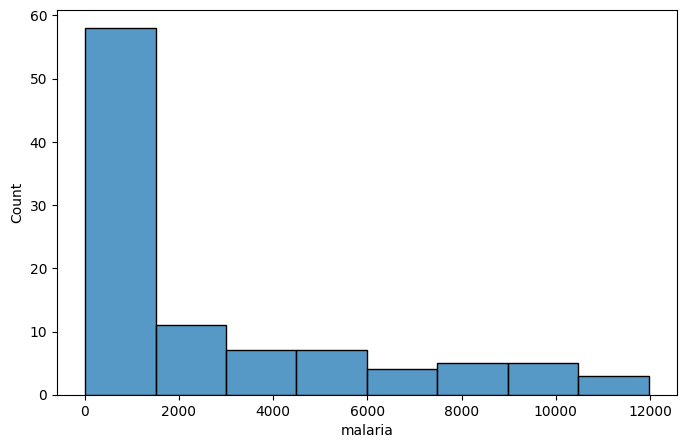

In [21]:
#df['malaria'].hist()

plt.figure(figsize=(8, 5))
#fig, ax = plt.subplots(figsize=(8, 5))
sns.histplot(data=df, x='malaria');

In [22]:
df['temperature_rolling_3']

20     29.633333
21     30.300000
22     30.466667
23     28.366667
24     25.733333
         ...    
115    29.500000
116    27.933333
117    29.000000
118    30.300000
119    30.133333
Name: temperature_rolling_3, Length: 100, dtype: float64

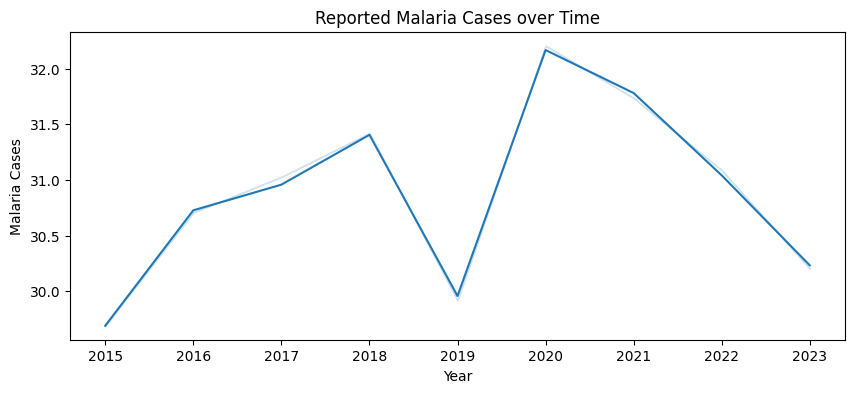

In [23]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(ax=ax, data=df, x='date', y='temperature_rolling_3', ci=False)
plt.xlabel("Year")
plt.ylabel('Malaria Cases')
plt.title("Reported Malaria Cases over Time");

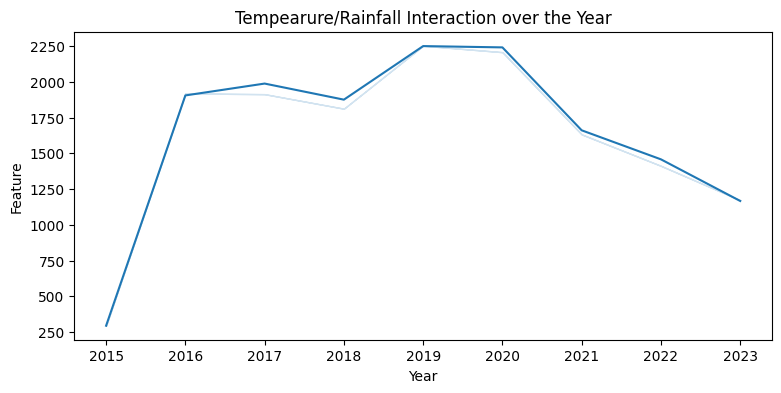

In [24]:
fig, ax = plt.subplots(figsize=(9, 4))
sns.lineplot(ax=ax, data=df, x='date', y='temp_rain_interaction', ci=False)
plt.xlabel("Year")
plt.ylabel('Feature')
plt.title("Tempearure/Rainfall Interaction over the Year");

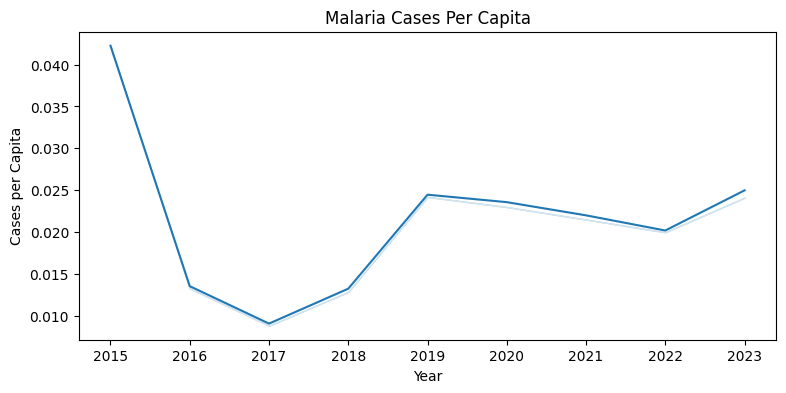

In [25]:
fig, ax = plt.subplots(figsize=(9, 4))
sns.lineplot(ax=ax, data=df, x='date', y='cases_per_capita', ci=False)
plt.xlabel("Year")
plt.ylabel('Cases per Capita')
plt.title("Malaria Cases Per Capita");

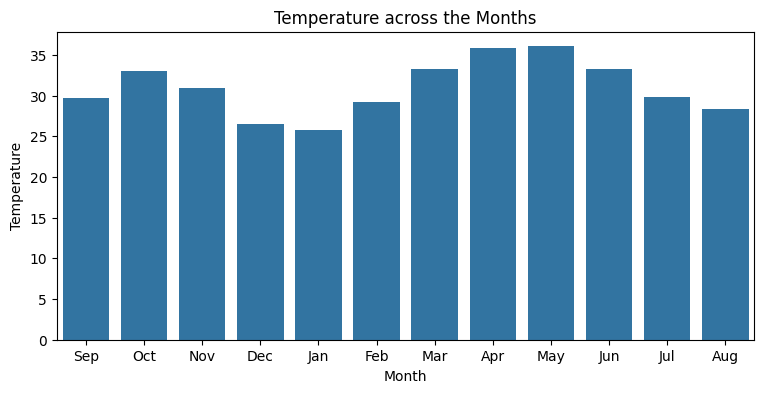

In [26]:
fig, ax = plt.subplots(figsize=(9, 4))
sns.barplot(ax=ax, data=df, x='month', y='temperature', ci=False)
plt.xlabel("Month")
plt.ylabel('Temperature')
plt.title("Temperature across the Months");

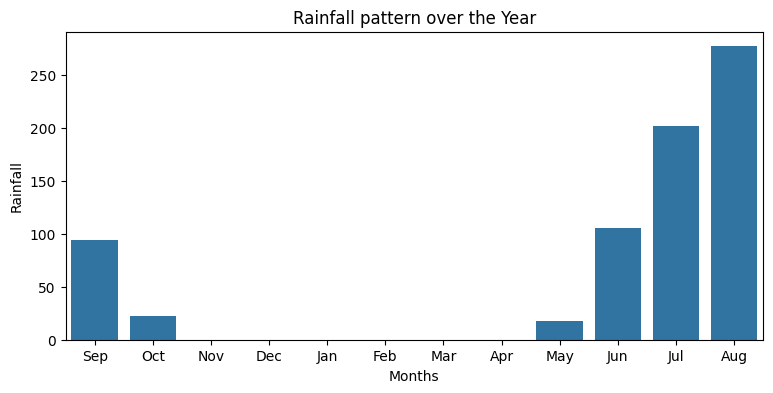

In [27]:
fig, ax = plt.subplots(figsize=(9, 4))
sns.barplot(ax=ax, data=df, x='month', y='rainfall', ci=False)
plt.xlabel("Months")
plt.ylabel('Rainfall')
plt.title("Rainfall pattern over the Year");

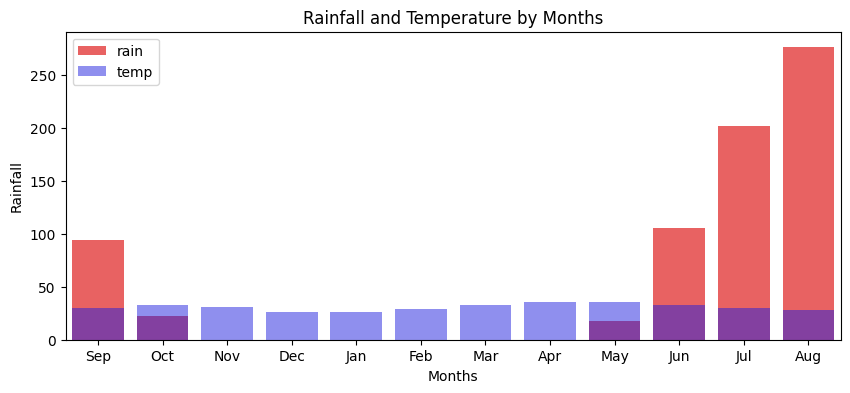

In [28]:
fig, ax = plt.subplots(figsize=(10, 4))
ft= sns.barplot(ax=ax, data=df, x='month', y='rainfall', ci=False, label='rain', color='r', alpha=.7)
sns.barplot(ax=ft, data=df, x='month', y='temperature', ci=False, label='temp', color='blue', alpha=.5)
plt.xlabel("Months")
plt.ylabel('Rainfall')
plt.title("Rainfall and Temperature by Months");

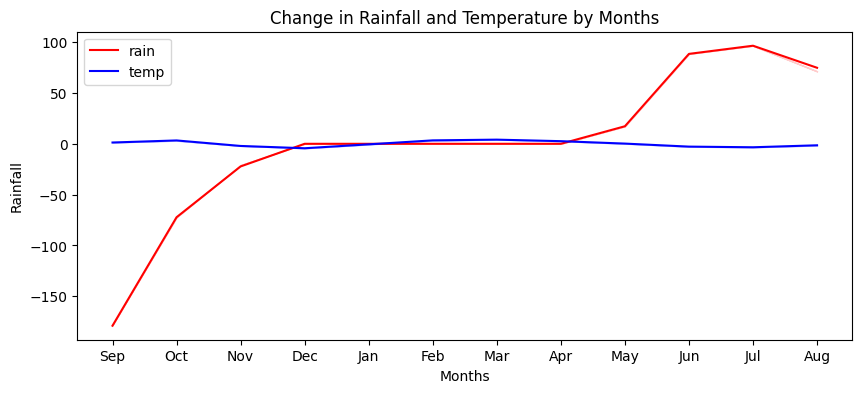

In [29]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(ax=ax, data=df, x='month', y='rainfall_change', ci=False, label='rain', color='r')
sns.lineplot(ax=ax, data=df, x='month', y='temperature_change', ci=False, label='temp', color='blue')
plt.xlabel("Months")
plt.ylabel('Rainfall')
plt.title("Change in Rainfall and Temperature by Months");

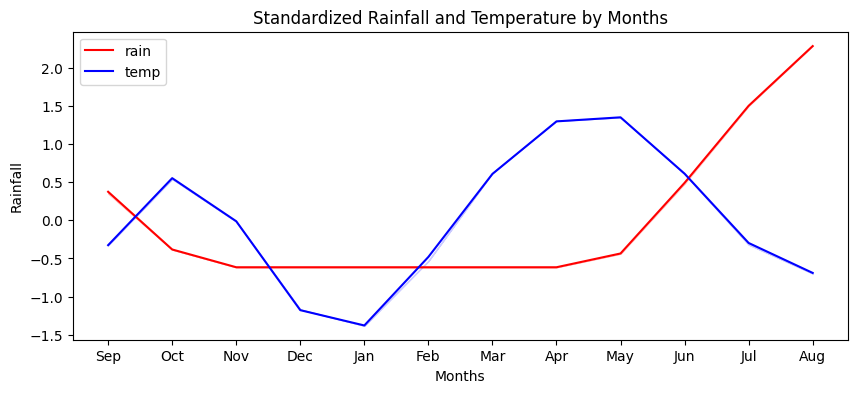

In [30]:
fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(ax=ax, data=df, x='month', y='rainfall_zscore', ci=False, label='rain', color='r')
sns.lineplot(ax=ax, data=df, x='month', y='temperature_zscore', ci=False, label='temp', color='blue')
plt.xlabel("Months")
plt.ylabel('Rainfall')
plt.title("Standardized Rainfall and Temperature by Months");

In [31]:
df.columns

Index(['month', 'rainfall', 'temperature', 'malaria', 'date', 'month_num',
       'season', 'temp_rain_interaction', 'cases_per_capita', 'cases_per_km2',
       'rainfall_change', 'temperature_change', 'rainfall_zscore',
       'temperature_zscore', 'cumulative_rainfall', 'cumulative_temperature',
       'humidity_index', 'rainfall_lag_1', 'temperature_lag_1',
       'rainfall_lag_5', 'temperature_lag_5', 'rainfall_lag_13',
       'temperature_lag_13', 'rainfall_lag_20', 'temperature_lag_20',
       'rainfall_rolling_3', 'temperature_rolling_3', 'rainfall_rolling_7',
       'temperature_rolling_7', 'rainfall_rolling_14',
       'temperature_rolling_14', 'extreme_rain', 'extreme_temp'],
      dtype='object')

<Figure size 900x400 with 0 Axes>

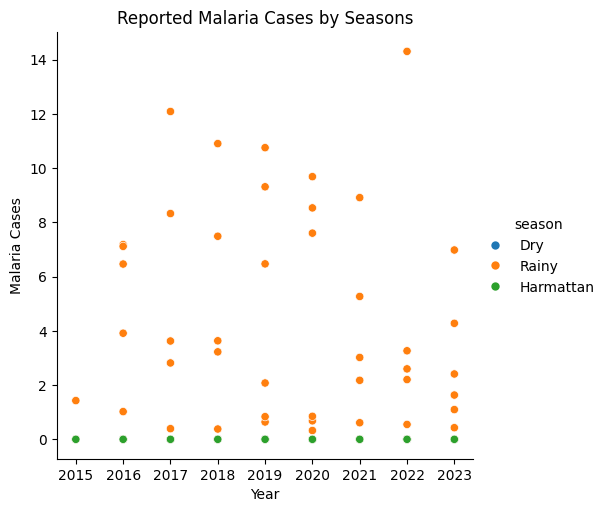

In [32]:
plt.figure(figsize=(9, 4))
sns.relplot(data=df, 
            x = 'date',
            y='humidity_index',
            #col='months',
            hue='season',
            kind='scatter')

plt.xlabel("Year")
plt.ylabel('Malaria Cases')
plt.title("Reported Malaria Cases by Seasons");

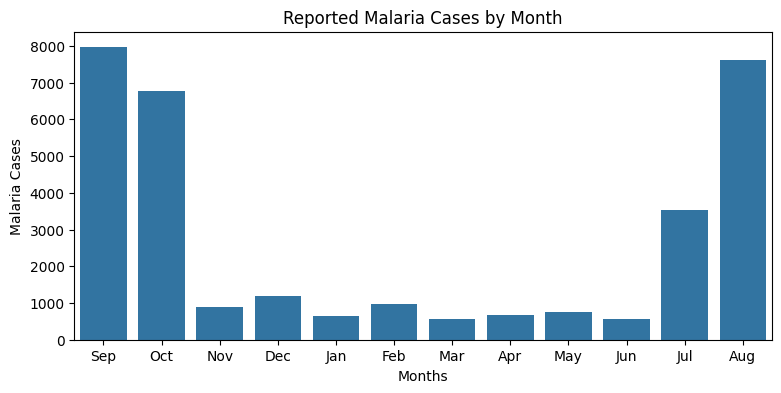

In [33]:
fig, ax = plt.subplots(figsize=(9, 4))
sns.barplot(ax=ax, data=df, x='month', y='malaria', ci=False)
plt.xlabel("Months")
plt.ylabel('Malaria Cases')
plt.title("Reported Malaria Cases by Month");

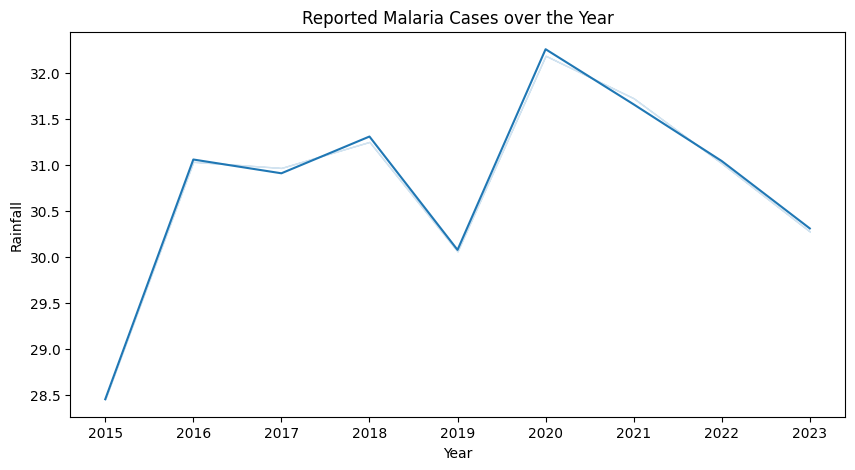

In [34]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(ax=ax, data=df, x='date', y='temperature', ci=False)
plt.xlabel("Year")
plt.ylabel('Rainfall')
plt.title("Reported Malaria Cases over the Year");

Text(0.5, 1.0, 'Rainfall and Temperature by Month')

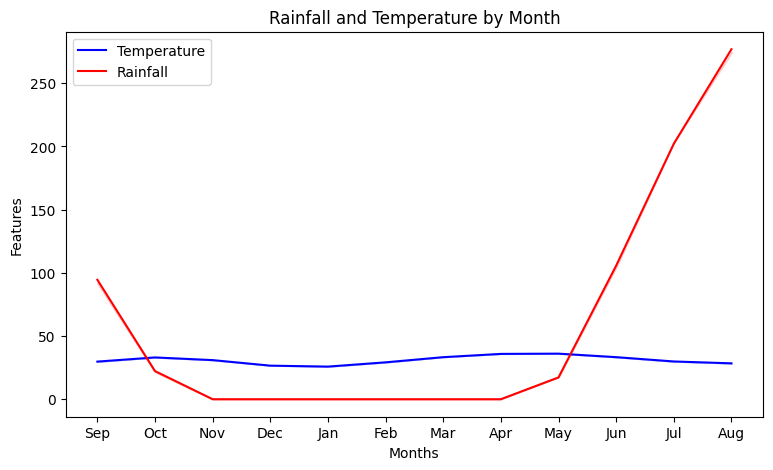

In [35]:
fig, ax = plt.subplots(figsize=(9, 5))
sns.lineplot(ax=ax, data=df, x='month', y='temperature', label='Temperature', color='b', ci=False)
sns.lineplot(ax=ax, data=df, x='month', y='rainfall', label='Rainfall', color='r', ci=False)
#sns.lineplot(ax=ax, data=df, x='months', y='malaria', label='Malaria', color='green', ci=False)#
plt.xlabel("Months")
plt.ylabel('Features')
plt.title("Rainfall and Temperature by Month")

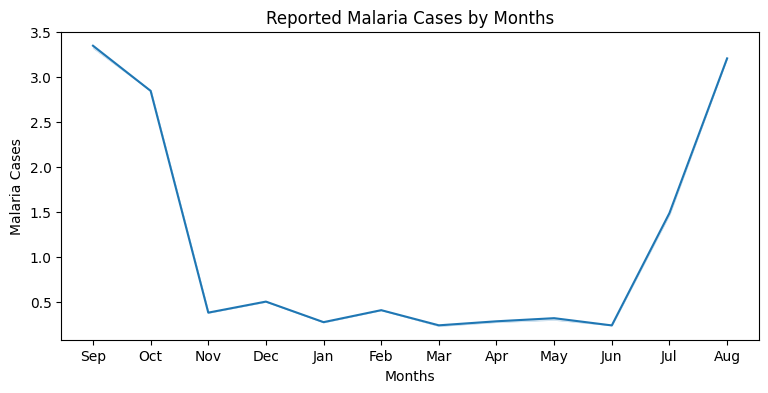

In [36]:
fig, ax = plt.subplots(figsize=(9, 4))
sns.lineplot(ax=ax, data=df, x='month', y='cases_per_km2', ci=False)
plt.xlabel("Months")
plt.ylabel('Malaria Cases')
plt.title("Reported Malaria Cases by Months");

<Figure size 1200x800 with 0 Axes>

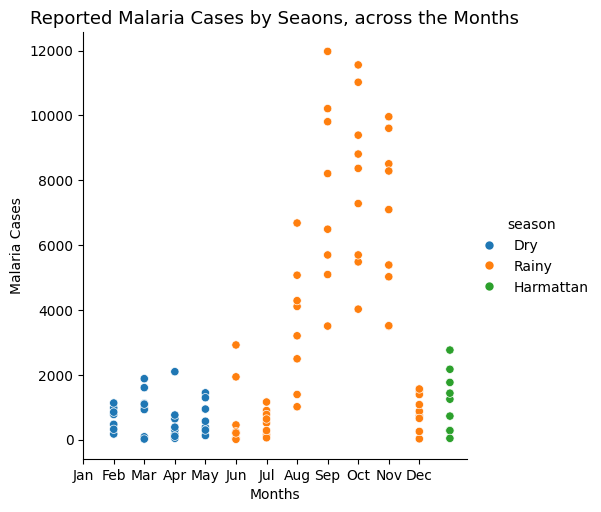

In [37]:
plt.figure(figsize=(12, 8))
sns.relplot(data=df,
            x = 'month_num',
            y='malaria',
            #col='months',
            hue='season',
            kind='scatter')

plt.xlabel("Months") 
plt.ylabel("Malaria Cases") 
plt.xticks(ticks=np.arange(12), labels=months)
plt.title("Reported Malaria Cases by Seaons, across the Months", fontsize=13);

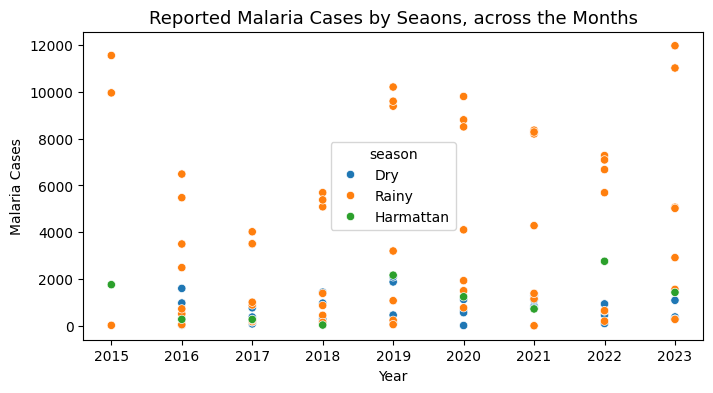

In [38]:
plt.figure(figsize=(8, 4))

sns.scatterplot(data=df, 
            x = 'date',
            y='malaria',
            #col='months',
            hue='season')

plt.xlabel("Year") 
plt.ylabel("Malaria Cases") 
#plt.xticks(ticks=np.arange(12), labels=months)
plt.title("Reported Malaria Cases by Seaons, across the Months", fontsize=13);

<Figure size 1000x400 with 0 Axes>

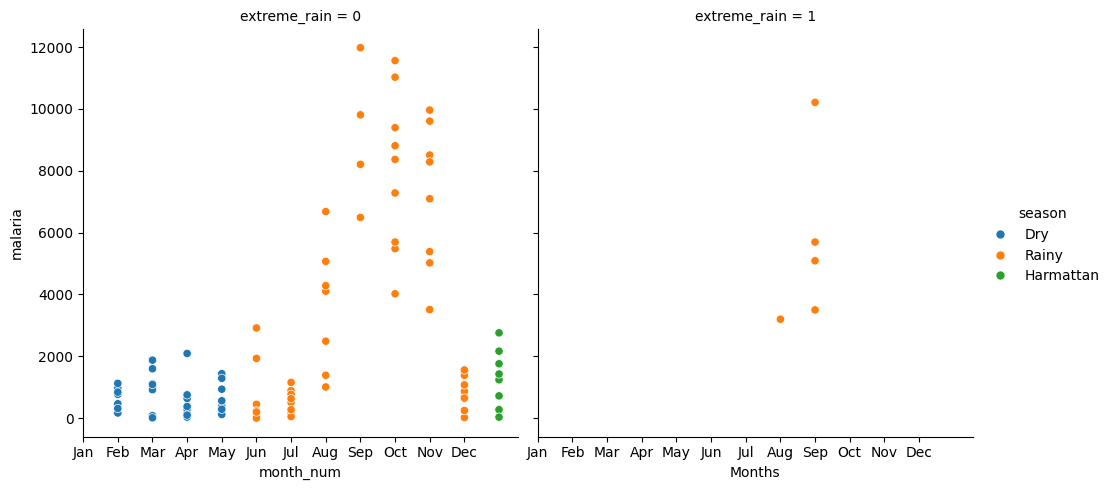

In [39]:
plt.figure(figsize=(10, 4))
sns.relplot(data=df,
            x = 'month_num',
            y='malaria',
            col='extreme_rain',
            hue='season',
            kind='scatter')

plt.xlabel("Months") 
plt.ylabel("Malaria Cases") 
plt.xticks(ticks=np.arange(12), labels=months);
#plt.title("Reported Malaria Cases by Seaons, across the Months", fontsize=13)

In [40]:
df

,month,rainfall,temperature,malaria,date,month_num,season,temp_rain_interaction,cases_per_capita,cases_per_km2,...,rainfall_lag_20,temperature_lag_20,rainfall_rolling_3,temperature_rolling_3,rainfall_rolling_7,temperature_rolling_7,rainfall_rolling_14,temperature_rolling_14,extreme_rain,extreme_temp
20,Sep,41.0,28.7,11557,2015,9,Rainy,1176.70,0.083807,4.859966,...,0.0,26.9,145.700000,29.633333,65.485714,32.614286,68.571429,30.535714,0,0
21,Oct,0.0,32.9,9959,2015,10,Rainy,0.00,0.072219,4.187973,...,0.0,28.4,95.600000,30.300000,65.485714,32.642857,45.014286,30.964286,0,0
22,Nov,0.0,29.8,23,2015,11,Rainy,0.00,0.000167,0.009672,...,0.0,33.6,13.666667,30.466667,65.485714,32.000000,35.192857,31.057143,0,0
23,Dec,0.0,22.4,1762,2015,12,Harmattan,0.00,0.012777,0.740959,...,0.0,35.8,0.000000,28.366667,65.485714,29.885714,32.742857,30.421429,0,1
24,Jan,0.0,25.0,978,2016,1,Dry,0.00,0.007092,0.411270,...,22.6,34.6,0.000000,25.733333,62.442857,28.428571,32.742857,30.007143,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,Aug,185.0,26.5,11974,2023,8,Rainy,4902.50,0.086831,5.035324,...,0.0,25.7,120.533333,29.500000,57.171429,31.028571,68.507143,29.700000,0,0
116,Sep,69.4,28.8,11022,2023,9,Rainy,1998.72,0.079927,4.634987,...,0.0,24.5,125.433333,27.933333,67.085714,31.528571,66.957143,29.764286,0,0
117,Oct,13.6,31.7,5022,2023,10,Rainy,431.12,0.036418,2.111859,...,0.0,37.4,89.333333,29.000000,69.028571,31.200000,41.057143,30.150000,0,0
118,Nov,0.0,30.4,1560,2023,11,Rainy,0.00,0.011313,0.656013,...,0.0,32.4,27.666667,30.300000,69.028571,30.657143,35.750000,30.278571,0,0


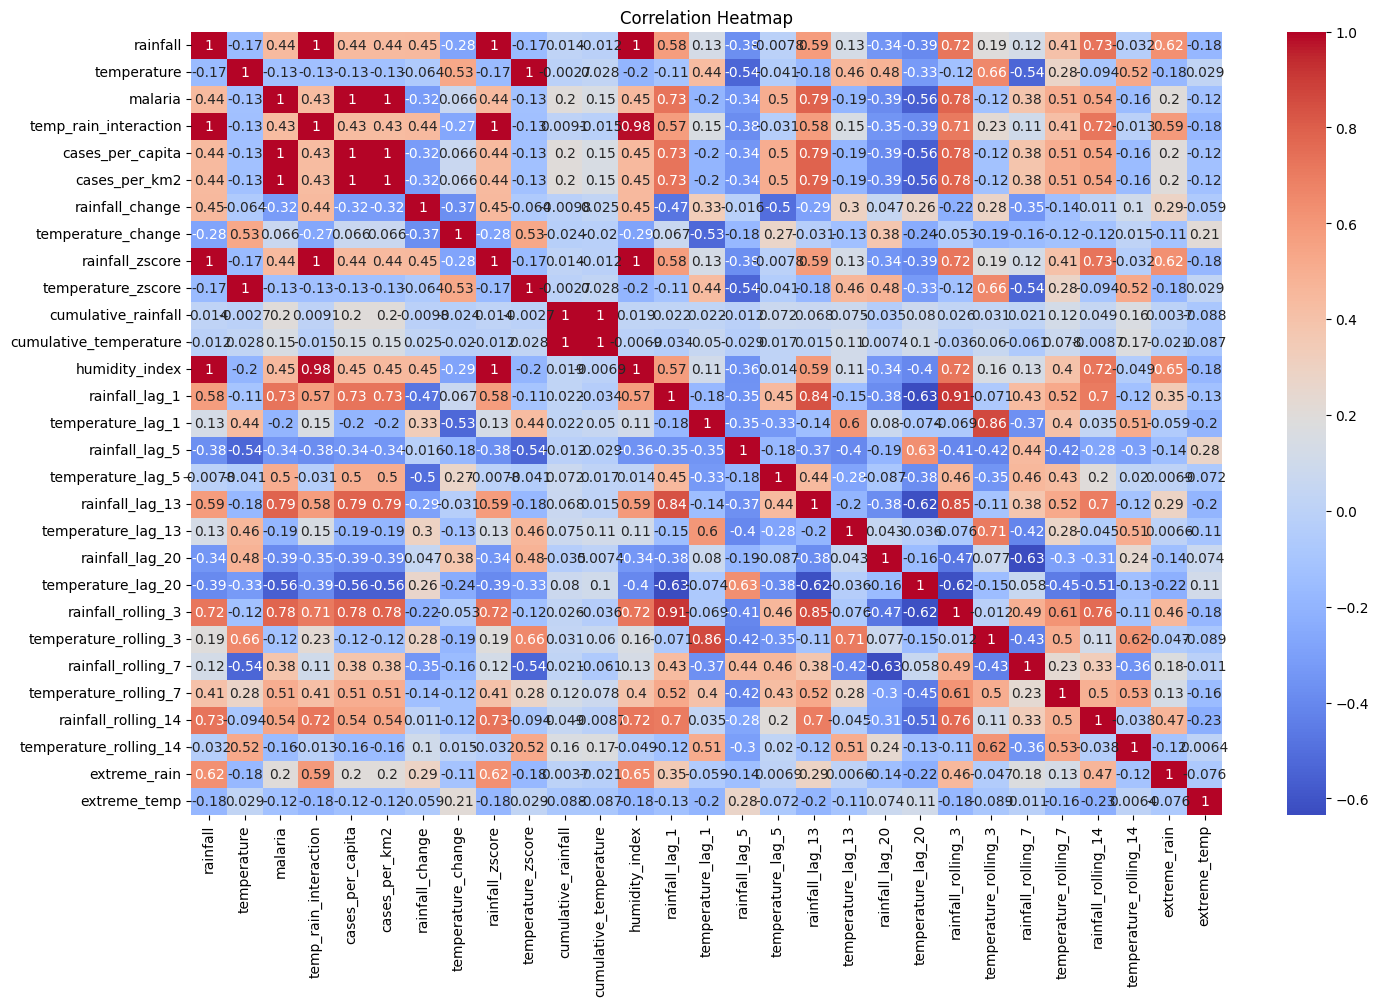

In [42]:
to_drop = ['month', 'season', 'date', 'month_num']

fig, ax = plt.subplots(figsize=(15, 10))
correl = df.drop(columns=to_drop).corr()
sns.heatmap(correl, annot=True, cmap='coolwarm')
fig.tight_layout()
plt.title("Correlation Heatmap");

<Axes: xlabel='season', ylabel='count'>

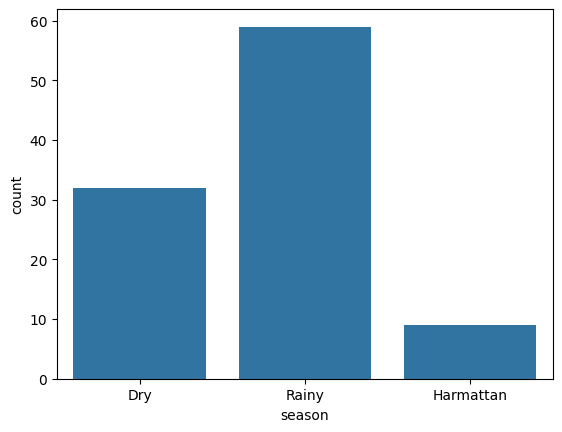

In [43]:
sns.countplot(data=df, x='season')

In [44]:
cols_to_drop = ['month', 'date', 'season', 'cases_per_capita', 'cases_per_km2', 'temp_rain_interaction', 'rainfall_zscore', 'temperature_zscore', 'humidity_index']
df.drop(columns=cols_to_drop, inplace=True)
df

,rainfall,temperature,malaria,month_num,rainfall_change,temperature_change,cumulative_rainfall,cumulative_temperature,rainfall_lag_1,temperature_lag_1,...,rainfall_lag_20,temperature_lag_20,rainfall_rolling_3,temperature_rolling_3,rainfall_rolling_7,temperature_rolling_7,rainfall_rolling_14,temperature_rolling_14,extreme_rain,extreme_temp
20,41.0,28.7,11557,9,-204.8,-0.6,1230.5,650.5,245.8,29.3,...,0.0,26.9,145.700000,29.633333,65.485714,32.614286,68.571429,30.535714,0,0
21,0.0,32.9,9959,10,-41.0,4.2,1230.5,683.4,41.0,28.7,...,0.0,28.4,95.600000,30.300000,65.485714,32.642857,45.014286,30.964286,0,0
22,0.0,29.8,23,11,0.0,-3.1,1230.5,713.2,0.0,32.9,...,0.0,33.6,13.666667,30.466667,65.485714,32.000000,35.192857,31.057143,0,0
23,0.0,22.4,1762,12,0.0,-7.4,1230.5,735.6,0.0,29.8,...,0.0,35.8,0.000000,28.366667,65.485714,29.885714,32.742857,30.421429,0,1
24,0.0,25.0,978,1,0.0,2.6,1230.5,760.6,0.0,22.4,...,22.6,34.6,0.000000,25.733333,62.442857,28.428571,32.742857,30.007143,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,185.0,26.5,11974,8,63.1,-2.0,6974.6,3599.8,121.9,28.5,...,0.0,25.7,120.533333,29.500000,57.171429,31.028571,68.507143,29.700000,0,0
116,69.4,28.8,11022,9,-115.6,2.3,7044.0,3628.6,185.0,26.5,...,0.0,24.5,125.433333,27.933333,67.085714,31.528571,66.957143,29.764286,0,0
117,13.6,31.7,5022,10,-55.8,2.9,7057.6,3660.3,69.4,28.8,...,0.0,37.4,89.333333,29.000000,69.028571,31.200000,41.057143,30.150000,0,0
118,0.0,30.4,1560,11,-13.6,-1.3,7057.6,3690.7,13.6,31.7,...,0.0,32.4,27.666667,30.300000,69.028571,30.657143,35.750000,30.278571,0,0


In [45]:
X = df.drop('malaria', axis=1)
y = df['malaria']

In [46]:
tree = DecisionTreeRegressor(random_state=11)
linear = LinearRegression()
lasso = LassoCV(random_state=11)
random = RandomForestRegressor(random_state=11)

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=11)

In [48]:
# defining a function that fits, predicts and estimate the Root Mean Squared Error of instantiated Models
def eval(model):

    # fit the model on the training set
    model.fit(X_train, y_train)
    # predicts on the test set
    pred = model.predict(X_test)
    # estimates the root mean squared error
    rmse = np.sqrt(mean_squared_error(pred, y_test))

    return rmse

In [49]:
# using for loop to print the various RMSE
models = [linear, lasso, tree, random]
for i in models:
    rm = round(eval(i), 4)
    print(f"The Root Mean Squared Error for {i} is {rm}")

The Root Mean Squared Error for LinearRegression() is 1989.3725
The Root Mean Squared Error for LassoCV(random_state=11) is 1809.6529
The Root Mean Squared Error for DecisionTreeRegressor(random_state=11) is 1965.0833
The Root Mean Squared Error for RandomForestRegressor(random_state=11) is 1773.0658


In [50]:
%%time

params = {
    'max_depth': [3, 5, 10],
    'min_samples_split': [2, 4, 7],
    'min_samples_leaf': [1, 4, 6],
    'min_weight_fraction_leaf': [0.0, 0.2],
    'max_features': [5, 10]
}

grid = GridSearchCV(
    estimator=random,
    param_grid = params
)

grid.fit(X_train, y_train)

GridSearchCV(estimator=RandomForestRegressor(random_state=11),
             param_grid={'max_depth': [3, 5, 10], 'max_features': [5, 10],
                         'min_samples_leaf': [1, 4, 6],
                         'min_samples_split': [2, 4, 7],
                         'min_weight_fraction_leaf': [0.0, 0.2]})

In [51]:
grids = grid.best_estimator_
grids

RandomForestRegressor(max_depth=5, max_features=5, random_state=11)

In [52]:
grids.fit(X_train, y_train)
griddy = eval(grids)
griddy

1630.5059354121609

In [64]:
vt = VotingRegressor(estimators=[('lasso', lasso), ('linear', linear), ('forest', random), ('tree', tree)], n_jobs=1, verbose=False)
vt.fit(X_train, y_train)
vot, lin, rand, lass, trees = eval(vt), eval(linear), eval(random), eval(lasso), eval(tree)
vot

1622.0331938659567

In [54]:
st = StackingRegressor(estimators=[('lasso', lasso), ('forest', random), ('tree', tree)], final_estimator=linear, n_jobs=-1)
st.fit(X_train, y_train)
sta = eval(st)
sta

1628.304730949611

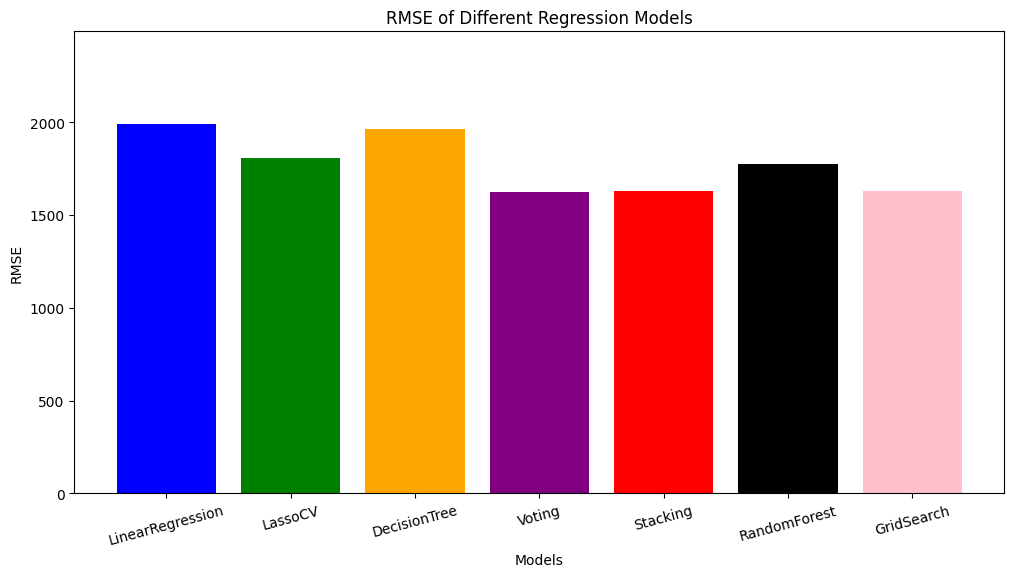

In [55]:
# RMSE values for the models
models = ['LinearRegression', 'LassoCV', 'DecisionTree','Voting', 'Stacking', 'RandomForest', 'GridSearch']
rmse_values = [lin, lass, trees, vot, sta, rand, griddy]

# Plotting the RMSE values
plt.figure(figsize=(12, 6))
plt.bar(models, rmse_values, color=['blue', 'green', 'orange', 'purple', 'red', 'black', 'pink'])
plt.xlabel('Models')
plt.ylabel('RMSE')
plt.title('RMSE of Different Regression Models')
plt.ylim(0, max(rmse_values) + 500)  # Adjust y-axis limit for better visualization
plt.xticks(rotation=15)  # Rotate x-axis labels for better readability
plt.show()

#### Since the `Voting Ensemble` has the least RMSE score, it will be adopted in making final prediction on the test set

In [56]:
pred = vt.predict(X_test)
pred

array([3778.18632079, 4185.02344044, 4216.1752777 , 4301.48069846,
        905.52045085, 2761.7796997 , 2554.64606344,   86.49133862,
        240.59683982,  810.28376677, 1113.33258181,  511.04320537,
       5177.75937037,  943.94158486,  222.60962527,  487.54997279,
       1382.59379205,  371.6125283 ,  106.02919478, 2504.05936359])

In [57]:
y_test

66     3201
69     9602
42     1012
78     4106
61     1878
118    1560
82     1503
49      973
50      296
71     2168
109    1092
98      101
103    5694
99      940
36      774
58      872
74      640
26       38
59       37
113     278
Name: malaria, dtype: int64

In [58]:
feat_imp = pd.DataFrame({"Coefficient": X_test.columns, "Importance": lasso.coef_}).sort_values("Importance", ascending=False)
top_feat = feat_imp.head()
top_feat

,Coefficient,Importance
15,rainfall_rolling_3,24.354430
11,rainfall_lag_13,15.427902
5,cumulative_rainfall,1.038353
1,temperature,-0.000000
21,extreme_rain,-0.000000


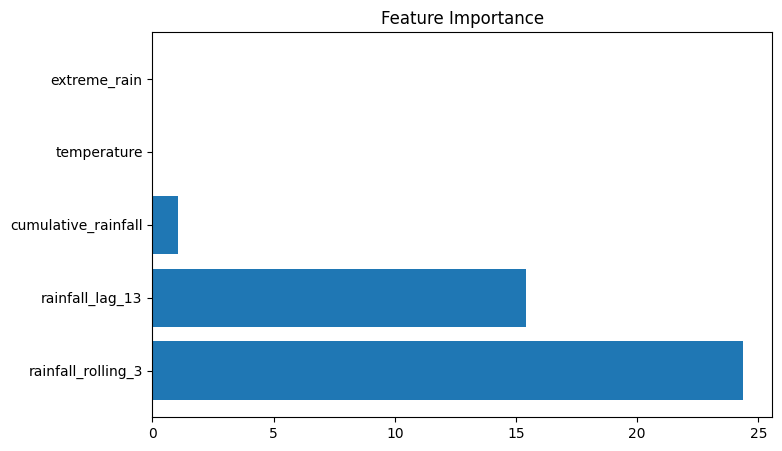

In [59]:
plt.figure(figsize=(8, 5))
plt.barh(top_feat['Coefficient'], top_feat['Importance'])
plt.title("Feature Importance");

In [61]:
import pickle

with open("dams.pkl", 'wb') as file:
    model = pickle.dump(vot, file)